# ML Pipeline Preparation
Follow the instructions below to help you create your ML pipeline.
### 1. Import libraries and load data from database.
- Import Python libraries
- Load dataset from database with [`read_sql_table`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_sql_table.html)
- Define feature and target variables X and Y

In [25]:
# import basic libraries
import os
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns 
from sqlalchemy import create_engine
# import nltk and text processing (like regular expresion) libraries
import nltk
nltk.download(['punkt', 'wordnet','stopwords'])
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
import re

# import libraries for transformation
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer

# import machine learning libraries
from sklearn.datasets import make_multilabel_classification
from sklearn.multioutput import MultiOutputClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, fbeta_score, make_scorer
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.ensemble import RandomForestClassifier
stop_words = stopwords.words("english")
lemmatizer = WordNetLemmatizer()

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [26]:
# load data from database
db_file = "./DisasterResponse.db"
# create the connection to the DB
engine = create_engine('sqlite:///DisasterResponse.db')
# prepare a table name
table_name = os.path.basename(db_file).replace(".db","")
# load the info from the sql table into a pandas file
df = pd.read_sql_table(table_name,engine)

# Exploratory Data Analysis (EDA)

Let's do some Exploratory Data Analysis.
First of all we'll see an overview of the dataset

In [27]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26216 entries, 0 to 26215
Data columns (total 40 columns):
id                        26216 non-null int64
message                   26216 non-null object
original                  10170 non-null object
genre                     26216 non-null object
related                   26216 non-null int64
request                   26216 non-null int64
offer                     26216 non-null int64
aid_related               26216 non-null int64
medical_help              26216 non-null int64
medical_products          26216 non-null int64
search_and_rescue         26216 non-null int64
security                  26216 non-null int64
military                  26216 non-null int64
child_alone               26216 non-null int64
water                     26216 non-null int64
food                      26216 non-null int64
shelter                   26216 non-null int64
clothing                  26216 non-null int64
money                     26216 non-null i

In [28]:
df.describe()

,id,related,request,offer,aid_related,medical_help,medical_products,search_and_rescue,security,military,...,aid_centers,other_infrastructure,weather_related,floods,storm,fire,earthquake,cold,other_weather,direct_report
count,26216.00000,26216.000000,26216.000000,26216.000000,26216.000000,26216.000000,26216.000000,26216.000000,26216.000000,26216.000000,...,26216.000000,26216.000000,26216.000000,26216.000000,26216.000000,26216.000000,26216.000000,26216.000000,26216.000000,26216.000000
mean,15224.82133,0.773650,0.170659,0.004501,0.414251,0.079493,0.050084,0.027617,0.017966,0.032804,...,0.011787,0.043904,0.278341,0.082202,0.093187,0.010757,0.093645,0.020217,0.052487,0.193584
std,8826.88914,0.435276,0.376218,0.066940,0.492602,0.270513,0.218122,0.163875,0.132831,0.178128,...,0.107927,0.204887,0.448191,0.274677,0.290700,0.103158,0.291340,0.140743,0.223011,0.395114
min,2.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,7446.75000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,15662.50000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,22924.25000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,30265.00000,2.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


We can see there are 40 columns and 26216 entries and our dataset has a memory usage: of 8.0+ MB
The dataset is pretty complete, with almost all its values (non-null).
There are three string fields and the rest of fields are of type integer
If we look at the fields, the major part of them are values between [0-1] except the "id" field and the "related" field whose values are between [0-2].
As it was stated, all values have to be binary, so we are going to explore this field

Now let's see how many records of every "related" field are. 
We will use these query for the final visualization part

In [29]:
df.groupby("related").count()

,id,message,original,genre,request,offer,aid_related,medical_help,medical_products,search_and_rescue,...,aid_centers,other_infrastructure,weather_related,floods,storm,fire,earthquake,cold,other_weather,direct_report
related,,,,,,,,,,,,,,,,,,,,,
0,6122,6122,3395,6122,6122,6122,6122,6122,6122,6122,...,6122,6122,6122,6122,6122,6122,6122,6122,6122,6122
1,19906,19906,6643,19906,19906,19906,19906,19906,19906,19906,...,19906,19906,19906,19906,19906,19906,19906,19906,19906,19906
2,188,188,132,188,188,188,188,188,188,188,...,188,188,188,188,188,188,188,188,188,188


In [31]:
df[df['related'] ==2].head()

,id,message,original,genre,related,request,offer,aid_related,medical_help,medical_products,...,aid_centers,other_infrastructure,weather_related,floods,storm,fire,earthquake,cold,other_weather,direct_report
117,146,Dans la zone de Saint Etienne la route de Jacm...,Nan zon st. etine rout jakmel la bloke se mize...,direct,2,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
219,263,. .. i with limited means. Certain patients co...,t avec des moyens limites. Certains patients v...,direct,2,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
305,373,The internet caf Net@le that's by the Dal road...,Cyber cafe net@le ki chita rout de dal tou pr ...,direct,2,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
460,565,"Bonsoir, on est a bon repos aprs la compagnie ...",Bonswa nou nan bon repo apri teleko nan wout t...,direct,2,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
576,700,URGENT CRECHE ORPHANAGE KAY TOUT TIMOUN CROIX ...,r et Salon Furterer. mwen se yon Cosmtologue. ...,direct,2,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [32]:
df[df['related'] ==2].describe()

,id,related,request,offer,aid_related,medical_help,medical_products,search_and_rescue,security,military,...,aid_centers,other_infrastructure,weather_related,floods,storm,fire,earthquake,cold,other_weather,direct_report
count,188.000000,188.0,188.0,188.0,188.0,188.0,188.0,188.0,188.0,188.0,...,188.0,188.0,188.0,188.0,188.0,188.0,188.0,188.0,188.0,188.0
mean,11703.340426,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
std,5479.507080,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
min,146.000000,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
25%,8956.000000,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
50%,13770.000000,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
75%,14376.750000,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
max,29126.000000,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [33]:
df[df['related'] ==0].describe()

,id,related,request,offer,aid_related,medical_help,medical_products,search_and_rescue,security,military,...,aid_centers,other_infrastructure,weather_related,floods,storm,fire,earthquake,cold,other_weather,direct_report
count,6122.000000,6122.0,6122.0,6122.0,6122.0,6122.0,6122.0,6122.0,6122.0,6122.0,...,6122.0,6122.0,6122.0,6122.0,6122.0,6122.0,6122.0,6122.0,6122.0,6122.0
mean,13819.700751,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
std,8843.881743,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
min,14.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
25%,6731.750000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
50%,10467.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
75%,22588.500000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
max,30262.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [34]:
df[df['related'] ==1].describe()

,id,related,request,offer,aid_related,medical_help,medical_products,search_and_rescue,security,military,...,aid_centers,other_infrastructure,weather_related,floods,storm,fire,earthquake,cold,other_weather,direct_report
count,19906.000000,19906.0,19906.000000,19906.000000,19906.000000,19906.000000,19906.000000,19906.000000,19906.000000,19906.000000,...,19906.000000,19906.000000,19906.000000,19906.000000,19906.000000,19906.000000,19906.000000,19906.000000,19906.000000,19906.000000
mean,15690.218025,1.0,0.224756,0.005928,0.545564,0.104692,0.065960,0.036371,0.023661,0.043203,...,0.015523,0.057822,0.366573,0.108259,0.122727,0.014167,0.123330,0.026625,0.069125,0.254948
std,8794.225162,0.0,0.417432,0.076766,0.497932,0.306164,0.248218,0.187216,0.151995,0.203319,...,0.123623,0.233412,0.481881,0.310715,0.328132,0.118180,0.328823,0.160989,0.253673,0.435843
min,2.000000,1.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,7896.250000,1.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,16595.000000,1.0,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,23058.750000,1.0,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
max,30265.000000,1.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


After exploring this field, there is not much information. 
Only that there are few entries of related field with value=2 compare to the rest of the values.
With the related value=2 we have two ways of working:
    1. We could impute them with another value, for instance value=1 that is the most often
    2. Drop them
And I will drop them

In [35]:
df = df[df.related !=2]

And we'll check

In [39]:
df['related'].describe()

count    26028.000000
mean         0.764792
std          0.424137
min          0.000000
25%          1.000000
50%          1.000000
75%          1.000000
max          1.000000
Name: related, dtype: float64

In [40]:
df.groupby("related").count()

,id,message,original,genre,request,offer,aid_related,medical_help,medical_products,search_and_rescue,...,aid_centers,other_infrastructure,weather_related,floods,storm,fire,earthquake,cold,other_weather,direct_report
related,,,,,,,,,,,,,,,,,,,,,
0,6122,6122,3395,6122,6122,6122,6122,6122,6122,6122,...,6122,6122,6122,6122,6122,6122,6122,6122,6122,6122
1,19906,19906,6643,19906,19906,19906,19906,19906,19906,19906,...,19906,19906,19906,19906,19906,19906,19906,19906,19906,19906


Now we'll check the 10 first lines of the dataset

In [41]:
df.head(10)

,id,message,original,genre,related,request,offer,aid_related,medical_help,medical_products,...,aid_centers,other_infrastructure,weather_related,floods,storm,fire,earthquake,cold,other_weather,direct_report
0,2,Weather update - a cold front from Cuba that c...,Un front froid se retrouve sur Cuba ce matin. ...,direct,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,7,Is the Hurricane over or is it not over,Cyclone nan fini osinon li pa fini,direct,1,0,0,1,0,0,...,0,0,1,0,1,0,0,0,0,0
2,8,Looking for someone but no name,"Patnm, di Maryani relem pou li banm nouvel li ...",direct,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,9,UN reports Leogane 80-90 destroyed. Only Hospi...,UN reports Leogane 80-90 destroyed. Only Hospi...,direct,1,1,0,1,0,1,...,0,0,0,0,0,0,0,0,0,0
4,12,"says: west side of Haiti, rest of the country ...",facade ouest d Haiti et le reste du pays aujou...,direct,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,14,Information about the National Palace-,Informtion au nivaux palais nationl,direct,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6,15,Storm at sacred heart of jesus,Cyclone Coeur sacr de jesus,direct,1,0,0,0,0,0,...,0,0,1,0,1,0,0,0,0,0
7,16,"Please, we need tents and water. We are in Sil...",Tanpri nou bezwen tant avek dlo nou zon silo m...,direct,1,1,0,1,0,0,...,0,0,0,0,0,0,0,0,0,1
8,17,"I would like to receive the messages, thank you",Mwen ta renmen jouin messag yo. Merci,direct,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9,18,I am in Croix-des-Bouquets. We have health iss...,"Nou kwadebouke, nou gen pwoblem sant m yo nan ...",direct,1,1,0,1,1,1,...,0,0,0,0,0,0,0,0,0,1


## Pearson correlation between variables
Let's build a heatmap, to see the correlation of each variable

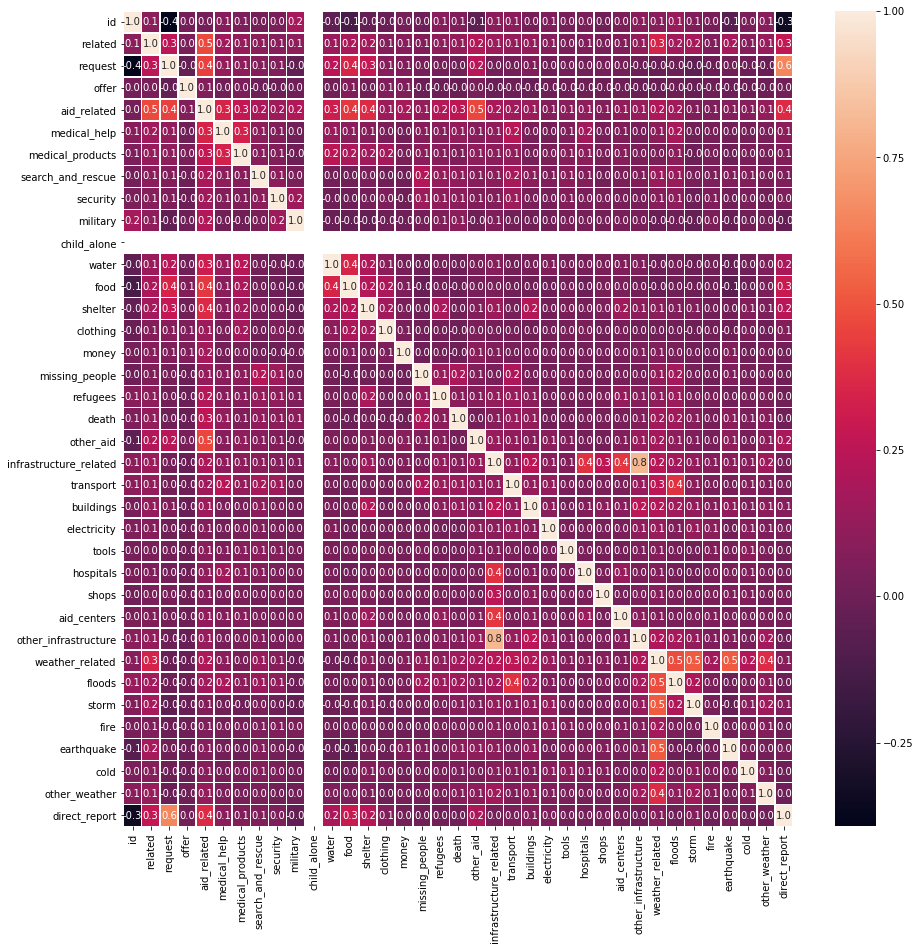

In [42]:
data = df.copy()
f,ax = plt.subplots(figsize=(15, 15))
sns.heatmap(data.corr(), annot=True, linewidths=.5, fmt= '.1f',ax=ax)
plt.show()

From this Pearson map, we clearly see there is a strange column "child_alone"
Let's explore more in detail 

In [43]:
df.groupby("child_alone").count()

,id,message,original,genre,related,request,offer,aid_related,medical_help,medical_products,...,aid_centers,other_infrastructure,weather_related,floods,storm,fire,earthquake,cold,other_weather,direct_report
child_alone,,,,,,,,,,,,,,,,,,,,,
0,26028,26028,10038,26028,26028,26028,26028,26028,26028,26028,...,26028,26028,26028,26028,26028,26028,26028,26028,26028,26028


We see that column only contains zero values so we are going to delete them, as it doesn't bring us much help

In [44]:
df = df.drop(["child_alone"],axis=1)

Let's see the Pearson again

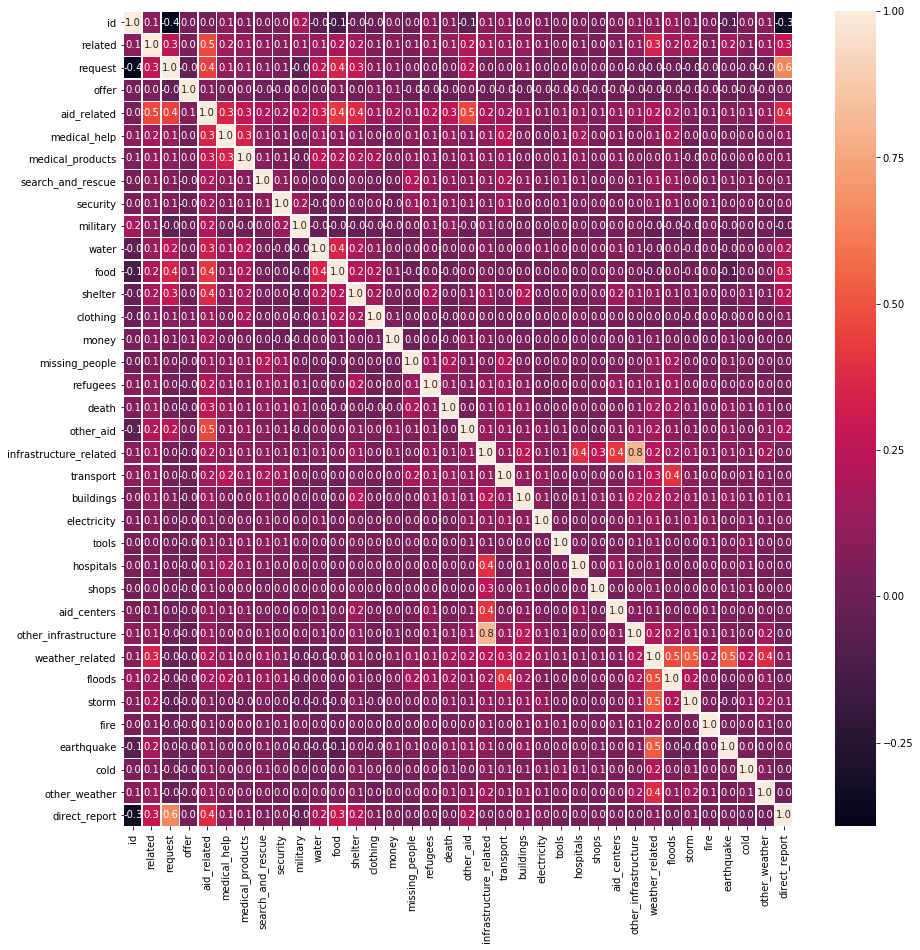

In [45]:
data = df.copy()
f,ax = plt.subplots(figsize=(15, 15))
sns.heatmap(data.corr(), annot=True, linewidths=.5, fmt= '.1f',ax=ax)
plt.show()

We have a glimpse of the data!!

Now, we will start with the Machine Learning tasks

In [12]:
# We separate the features from the variables we are going to predict
X = df ['message']
y = df.drop(columns = ['id', 'message', 'original', 'genre'])

### 2. Tokenization function to process your text data

In [13]:
def tokenize(text):
    # normalize case and remove punctuation
    text = re.sub(r"[^a-zA-Z0-9]", " ", text.lower())
    
    # tokenize text
    tokens = word_tokenize(text)
    
    # lemmatize andremove stop words
    tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words]

    return tokens

### 3. Build a machine learning pipeline
This machine pipeline should take in the `message` column as input and output classification results on the other 36 categories in the dataset. You may find the [MultiOutputClassifier](http://scikit-learn.org/stable/modules/generated/sklearn.multioutput.MultiOutputClassifier.html) helpful for predicting multiple target variables.

In [14]:
pipeline = Pipeline([
        ('vect', CountVectorizer(tokenizer=tokenize)),
        ('tfidf', TfidfTransformer()),
        ('clf', MultiOutputClassifier (RandomForestClassifier())) 
    ])

### 4. Train pipeline
- Split data into train and test sets
- Train pipeline

In [15]:
X_train, X_test, y_train, y_test = train_test_split(X, y)

# train classifier
pipeline.fit(X_train, y_train) 

Pipeline(memory=None,
     steps=[('vect', CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words=None,
        strip...oob_score=False, random_state=None, verbose=0,
            warm_start=False),
           n_jobs=1))])

### 5. Test your model
Report the f1 score, precision and recall for each output category of the dataset. You can do this by iterating through the columns and calling sklearn's `classification_report` on each.

In [16]:
# predict on test data
y_pred = pipeline.predict(X_test)

In [17]:
# we check dimensions
X_train.shape, y_train.shape, y.shape, X.shape

((19662,), (19662, 35), (26216, 35), (26216,))

In [18]:
# and print metrics
accuracy = (y_pred == y_test).mean()
print("Accuracy:", accuracy, "\n")

category_names = list(y.columns)

for i in range(len(category_names)):
    print("Output Category:", category_names[i],"\n", classification_report(y_test.iloc[:, i].values, y_pred[:, i]))
    print('Accuracy of %25s: %.2f' %(category_names[i], accuracy_score(y_test.iloc[:, i].values, y_pred[:,i])))


Accuracy: related                   0.805920
request                   0.884803
offer                     0.994355
aid_related               0.763198
medical_help              0.922338
medical_products          0.950717
search_and_rescue         0.973451
security                  0.982606
military                  0.972078
water                     0.948581
food                      0.932865
shelter                   0.937138
clothing                  0.989472
money                     0.979402
missing_people            0.987489
refugees                  0.964602
death                     0.958956
other_aid                 0.870613
infrastructure_related    0.932408
transport                 0.955294
buildings                 0.956057
electricity               0.980623
tools                     0.994202
hospitals                 0.988709
shops                     0.994965
aid_centers               0.988099
other_infrastructure      0.956515
weather_related           0.866341
floods    

/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


### 6. Improve your model
Use grid search to find better parameters. 

In [19]:
base = Pipeline([
        ('vect', CountVectorizer(tokenizer=tokenize)),
        ('tfidf', TfidfTransformer()),
        ('clf', MultiOutputClassifier(RandomForestClassifier()))
        ])
    
parameters = {'clf__estimator__n_estimators': [10, 20],
              'clf__estimator__max_depth': [2, 5],
              'clf__estimator__min_samples_split': [2, 3, 4],
              'clf__estimator__criterion': ['entropy']
                 }
    
cv = GridSearchCV(base, param_grid=parameters, n_jobs=-1, cv=2, verbose=3)

In [20]:
cv.fit(X_train, y_train)

Fitting 2 folds for each of 12 candidates, totalling 24 fits
[CV] clf__estimator__criterion=entropy, clf__estimator__max_depth=2, clf__estimator__min_samples_split=2, clf__estimator__n_estimators=10 
[CV]  clf__estimator__criterion=entropy, clf__estimator__max_depth=2, clf__estimator__min_samples_split=2, clf__estimator__n_estimators=10, score=0.20160716102125928, total=  10.1s
[CV] clf__estimator__criterion=entropy, clf__estimator__max_depth=2, clf__estimator__min_samples_split=2, clf__estimator__n_estimators=10 


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:   14.6s remaining:    0.0s


[CV]  clf__estimator__criterion=entropy, clf__estimator__max_depth=2, clf__estimator__min_samples_split=2, clf__estimator__n_estimators=10, score=0.20272607059302208, total=  10.1s
[CV] clf__estimator__criterion=entropy, clf__estimator__max_depth=2, clf__estimator__min_samples_split=2, clf__estimator__n_estimators=20 


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:   29.2s remaining:    0.0s


[CV]  clf__estimator__criterion=entropy, clf__estimator__max_depth=2, clf__estimator__min_samples_split=2, clf__estimator__n_estimators=20, score=0.20201403722917302, total=  11.3s
[CV] clf__estimator__criterion=entropy, clf__estimator__max_depth=2, clf__estimator__min_samples_split=2, clf__estimator__n_estimators=20 
[CV]  clf__estimator__criterion=entropy, clf__estimator__max_depth=2, clf__estimator__min_samples_split=2, clf__estimator__n_estimators=20, score=0.20313294680093583, total=  11.2s
[CV] clf__estimator__criterion=entropy, clf__estimator__max_depth=2, clf__estimator__min_samples_split=3, clf__estimator__n_estimators=10 
[CV]  clf__estimator__criterion=entropy, clf__estimator__max_depth=2, clf__estimator__min_samples_split=3, clf__estimator__n_estimators=10, score=0.2019123181771946, total=  10.0s
[CV] clf__estimator__criterion=entropy, clf__estimator__max_depth=2, clf__estimator__min_samples_split=3, clf__estimator__n_estimators=10 
[CV]  clf__estimator__criterion=entropy, 

[Parallel(n_jobs=-1)]: Done  24 out of  24 | elapsed:  6.3min finished


GridSearchCV(cv=2, error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('vect', CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words=None,
        strip...oob_score=False, random_state=None, verbose=0,
            warm_start=False),
           n_jobs=1))]),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'clf__estimator__n_estimators': [10, 20], 'clf__estimator__max_depth': [2, 5], 'clf__estimator__min_samples_split': [2, 3, 4], 'clf__estimator__criterion': ['entropy']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=3)

### 7. Test your model
Show the accuracy, precision, and recall of the tuned model.  

Since this project focuses on code quality, process, and  pipelines, there is no minimum performance metric needed to pass. However, make sure to fine tune your models for accuracy, precision and recall to make your project stand out - especially for your portfolio!

In [21]:
y_pred = cv.predict(X_test)

In [22]:
accuracy = (y_pred == y_test).mean()
print("Accuracy:", accuracy, "\n")
for i in range(len(category_names)):
    print("Output Category:", category_names[i],"\n", classification_report(y_test.iloc[:, i].values, y_pred[:, i]))
    print('Accuracy of %25s: %.2f' %(category_names[i], accuracy_score(y_test.iloc[:, i].values, y_pred[:,i])))


Accuracy: related                   0.758621
request                   0.827739
offer                     0.994355
aid_related               0.591700
medical_help              0.921575
medical_products          0.949649
search_and_rescue         0.971926
security                  0.983064
military                  0.970857
water                     0.934696
food                      0.890143
shelter                   0.915319
clothing                  0.987794
money                     0.978639
missing_people            0.987336
refugees                  0.965060
death                     0.953464
other_aid                 0.869698
infrastructure_related    0.934544
transport                 0.954074
buildings                 0.952853
electricity               0.980165
tools                     0.994202
hospitals                 0.988709
shops                     0.994965
aid_centers               0.988099
other_infrastructure      0.956820
weather_related           0.724291
floods    

/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


### 8. Try improving your model further. Here are a few ideas:
* try other machine learning algorithms
* add other features besides the TF-IDF

In [23]:
from sklearn.decomposition import TruncatedSVD
import sklearn

base = Pipeline([
                ('vect',CountVectorizer(tokenizer=tokenize)),
                ('tfidf', TfidfTransformer()),
                ('lsa', TruncatedSVD(random_state=42, n_components=100)),
               # ('clf', MultiOutputClassifier(sklearn.svm.SVC(random_state=42, class_weight='balanced', gamma='scale')))
                ('clf', MultiOutputClassifier(sklearn.svm.SVC(random_state=42)))
           ])

# SVC parameters
parameters = {'clf__estimator__kernel': ['linear', 'rbf'],
              'clf__estimator__C': [0.1, 1, 5]
             }

cv = GridSearchCV(base, param_grid=parameters, n_jobs=-1, cv=2, scoring='f1_samples',verbose=3)

In [24]:
cv.fit(X_train, y_train)

Fitting 2 folds for each of 6 candidates, totalling 12 fits
[CV] clf__estimator__C=0.1, clf__estimator__kernel=linear ............


/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in samples with no predicted labels.
  'precision', 'predicted', average, warn_for)
/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in samples with no true labels.
  'recall', 'true', average, warn_for)


[CV]  clf__estimator__C=0.1, clf__estimator__kernel=linear, score=0.47706630361875246, total= 2.7min
[CV] clf__estimator__C=0.1, clf__estimator__kernel=linear ............


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:  3.9min remaining:    0.0s
/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in samples with no predicted labels.
  'precision', 'predicted', average, warn_for)
/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in samples with no true labels.
  'recall', 'true', average, warn_for)


[CV]  clf__estimator__C=0.1, clf__estimator__kernel=linear, score=0.48132919132600893, total= 2.6min
[CV] clf__estimator__C=0.1, clf__estimator__kernel=rbf ...............


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:  7.6min remaining:    0.0s
/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in samples with no true labels.
  'recall', 'true', average, warn_for)


[CV]  clf__estimator__C=0.1, clf__estimator__kernel=rbf, score=0.4050511991977779, total= 3.5min
[CV] clf__estimator__C=0.1, clf__estimator__kernel=rbf ...............


/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in samples with no true labels.
  'recall', 'true', average, warn_for)


[CV]  clf__estimator__C=0.1, clf__estimator__kernel=rbf, score=0.4076369553234798, total= 3.6min
[CV] clf__estimator__C=1, clf__estimator__kernel=linear ..............


/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in samples with no predicted labels.
  'precision', 'predicted', average, warn_for)
/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in samples with no true labels.
  'recall', 'true', average, warn_for)


[CV]  clf__estimator__C=1, clf__estimator__kernel=linear, score=0.5145326342493431, total= 2.5min
[CV] clf__estimator__C=1, clf__estimator__kernel=linear ..............


/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in samples with no predicted labels.
  'precision', 'predicted', average, warn_for)
/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in samples with no true labels.
  'recall', 'true', average, warn_for)


[CV]  clf__estimator__C=1, clf__estimator__kernel=linear, score=0.5136615955600141, total= 2.5min
[CV] clf__estimator__C=1, clf__estimator__kernel=rbf .................


/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in samples with no true labels.
  'recall', 'true', average, warn_for)


[CV]  clf__estimator__C=1, clf__estimator__kernel=rbf, score=0.411692362288208, total= 3.8min
[CV] clf__estimator__C=1, clf__estimator__kernel=rbf .................


/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in samples with no true labels.
  'recall', 'true', average, warn_for)


[CV]  clf__estimator__C=1, clf__estimator__kernel=rbf, score=0.41575783236209285, total= 3.9min
[CV] clf__estimator__C=5, clf__estimator__kernel=linear ..............


/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in samples with no predicted labels.
  'precision', 'predicted', average, warn_for)
/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in samples with no true labels.
  'recall', 'true', average, warn_for)


[CV]  clf__estimator__C=5, clf__estimator__kernel=linear, score=0.5154923315080022, total= 2.7min
[CV] clf__estimator__C=5, clf__estimator__kernel=linear ..............


KeyboardInterrupt: 

In [ ]:
y_pred = cv.predict(X_test)

In [ ]:
accuracy = (y_pred == y_test).mean()
print("Accuracy:", accuracy, "\n")

category_names = list(y.columns)

for i in range(len(category_names)):
    print("Output Category:", category_names[i],"\n", classification_report(y_test.iloc[:, i].values, y_pred[:, i]))
    print('Accuracy of %25s: %.2f' %(category_names[i], accuracy_score(y_test.iloc[:, i].values, y_pred[:,i])))

### 9. Export your model as a pickle file

In [ ]:
def save_model(model, model_filepath):
    """
    Save the model as a pickle file:

    This procedure saves the model as a pickle file

    Args: model, X set, y set

    Returns:
        nothing, it runs the model and it displays accuracy metrics
    """
    try:        
        pickle.dump(model, open(model_filepath, 'wb'))
    except:
        print("Error saving the model as a {} pickle file".format(model_filepath))

In [ ]:
save_model(cv,"classifier2.pkl")

In [ ]:
pickle.dump(cv, open("classifier2.pkl", 'wb'))

### 10. Use this notebook to complete `train.py`
Use the template file attached in the Resources folder to write a script that runs the steps above to create a database and export a model based on a new dataset specified by the user.

# Refactoring

In [ ]:
 def load_data(db_file):
    """
    Load data function
    
    This method receives a database file on a path and it loads data 
    from that database file into a pandas datafile.
    It also splits the data into X and y (X: features to work and y: labels to predict)   
    It returns two sets of data: X and y
      
    Args: 
        db_file (str): Filepath where database is stored.
    
    Returns: 
        X (DataFrame): Feature columns
        y (DataFrame): Label columns
    
    """
    # load data from database
    # db_file = "./CleanDisasterResponse.db"
    # create the connection to the DB
    engine = create_engine('sqlite:///{}'.format(db_file))
    table_name = os.path.basename(db_file).replace(".db","")
    # load the info from the sql table into a pandas file
    df = pd.read_sql_table(table_name,engine)
    # We separate the features from the variables we are going to predict
    X = df ['message']
    y = df.drop(columns = ['id', 'message', 'original', 'genre'])

    return X, y

In [ ]:
def display_results(y_test, y_pred):
    labels = np.unique(y_pred)
    confusion_mat = confusion_matrix(y_test, y_pred, labels=labels)
    accuracy = (y_pred == y_test).mean()

    print("Labels:", labels)
    print("Confusion Matrix:\n", confusion_mat)
    print("Accuracy:", accuracy)

In [ ]:
A,b = load_data("./CleanDisasterResponse.db")

In [ ]:
def tokenize(text):
    """
    Tokenize function
    
    Args:
        This method receives a text and it tokenizes it   
    
    Returns: a set of tokens
    
    """
    # normalize case and remove punctuation
    text = re.sub(r"[^a-zA-Z0-9]", " ", text.lower())
    
    # tokenize text
    tokens = word_tokenize(text)
    
    # lemmatize andremove stop words
    tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words]

    return tokens

In [ ]:
def save_model(model, model_filepath):
    """
    Save the model as a pickle file:

    This procedure saves the model as a pickle file

    Args: model, X set, y set

    Returns:
        nothing, it runs the model and it displays accuracy metrics
    """
    pickle.dump(model, open(model_filepath, 'wb'))

And now let's try some queries to show interesting data on the html web

In [ ]:
top_10_mes = df.iloc[:,5:].sum().sort_values(ascending=False)[0:10]
top_10_mes
top_10_mes_names = list(top_10_mes.index)
top_10_mes_names

In [ ]:
mes_categories = df.columns[5:-1]
mes_categories

In [ ]:
mes_categories_count = df[mes_categories].sum()
mes_categories_count

In [ ]:
bottom_10_mes = df.iloc[:,5:].sum().sort_values()[0:10]
bottom_10_mes

In [ ]:
bottom_10_mes_names = list(bottom_10_mes.index)
bottom_10_mes_names

In [ ]:
distr_class_1 = df.drop(['id', 'message', 'original', 'genre'], axis = 1).sum()/len(df)

In [ ]:
distr_class_1 = distr_class_1.sort_values(ascending = False)

In [ ]:
distr_class_0 = 1 - distr_class_1

In [ ]:
distr_class_names = list(distr_class_1.index)

In [ ]:
list(distr_class_1.index)

In [ ]:
distr_class_1 = df.drop(['id', 'message', 'original', 'genre'], axis = 1).sum()/len(df)